# 4. Evaluation Metrics for Classification

Last week we trained a model for churn. How do we know if it's good?

The fourth week of Machine Learning Zoomcamp is about different metrics to evaluate a binary classifier. These measures include accuracy, confusion table, precision, recall, ROC curves(TPR, FRP, random model, and ideal model), AUROC, and cross-validation.

## 4.1 Evaluation metrics: session overview

- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [87]:
import urllib.request

In [88]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

filename = 'data-week-3.csv'

df = pd.read_csv(url)

In [89]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [90]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [91]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [92]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [93]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

Accurcy measures the fraction of correct predictions. Specifically, it is the number of correct predictions divided by the total number of predictions.

We can change the decision threshold, it should not be always 0.5. But, in this particular problem, the best decision cutoff, associated with the hightest accuracy (80%), was indeed 0.5.

Note that if we build a dummy model in which the decision cutoff is 1, so the algorithm predicts that no clients will churn, the accuracy would be 73%. Thus, we can see that the improvement of the original model with respect to the dummy model is not as high as we would expect.

Therefore, in this problem accuracy can not tell us how good is the model because the dataset is unbalanced, which means that there are more instances from one category than the other. This is also known as class imbalance.

Classes and methods:

- `np.linspace(x,y,z)` - returns a numpy array starting at x until y with a z step
- `Counter(x)` - collection class that counts the number of instances that satisfy the x condition
- `accuracy_score(x, y)` - sklearn.metrics class for calculating the accuracy of a model, given a predicted x dataset and a target y dataset.

In [94]:
len(y_val)

1409

In [95]:
(y_val == churn_decision).sum() / len(y_val)

0.8034066713981547

So we have the accuracy of our base model using 0.5 as the cutoff for churn, no churn.  Now we will vary the 0.5 to different numbers to see if the accuracy of our model is better or not.

The `np.linspace()` method can be used to create an array.  In this case we want the values in the array to be from 0 to 1 and we want 21 of them.  That will start at 0 and increment by .05 each step.

In [96]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [97]:
scores = []

for t in thresholds:
    
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


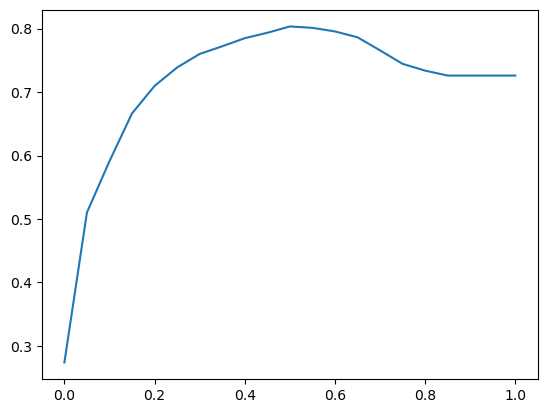

In [98]:
plt.plot(thresholds, scores)

We can see that 0.5 is the best one.  We used our own function for calculating accuracy `(y_val == churn_decision).mean()`. sklearn has a function for accuracy, `accuracy_score`.  Let's implement that.

In [99]:
from sklearn.metrics import accuracy_score

In [100]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

Let's add that into our previous function to calculate accuracy with the `thresholds` array.

In [101]:
scores = []

for t in thresholds:
    
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.734
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


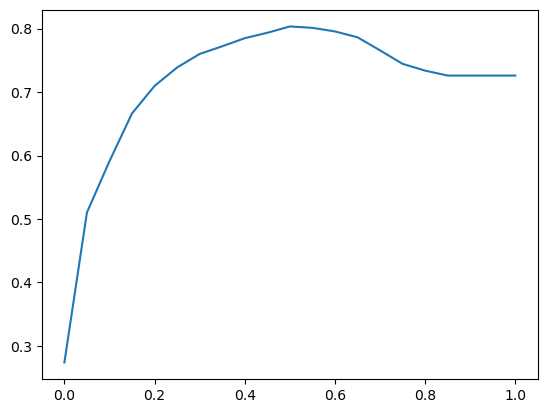

In [102]:
plt.plot(thresholds, scores)

At the threshold of 1.0 we can see our prediction rate is 72.6%.  That must mean that our churn rate in the validation set is 72.6%.  Let's verify that using the `Counter` method, which simply counts the number of True or False.  

In [103]:
from collections import Counter

In [104]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

As we can see the number of False records is at 1409, which is the size of our array, so none of the values are greater than 1. Below we can simply do a small calculation and see that it is simply a calculation of the churn rate of our dataset.

In [105]:
1 - y_val.mean()

0.7260468417317246

So the actual non churn rate is at 72.6% for the validation dataset and our model is only 7.4% better.  So accuracy isn't the best choice for scoring our model.  This is because we have what is called class imbalance. We have 72.6% of customers that don't churn compared to 27.4% of customers that do churn.

In [106]:
y_val.mean()

0.2739531582682754

## 4.3 Confusion table

Confusion table is a way to measure different types of errors and correct decisions that binary classifiers can made. Considering this information, it is possible evaluate the quality of the model by different strategies.

If we predict the probability of churning from a customer, we have the following scenarios:

- No churn - Negative class
    - Customer did not churn - True Negative (TN)
    - Customer churned - False Negative (FN)
- Churn - Positive class
    - Customer churned - True Positive (TP)
    - Customer did not churn - False Positive (FP)

The confusion table help us to summarize the measures explained above in a tabular format, as is shown below:

| Actual/Predictions | Negative | Postive |
| --- | --- | --- |
| Negative | TN | FP |
| Postive | FN | TP |

The accuracy corresponds to the sum of TN and TP divided by the total of observations.
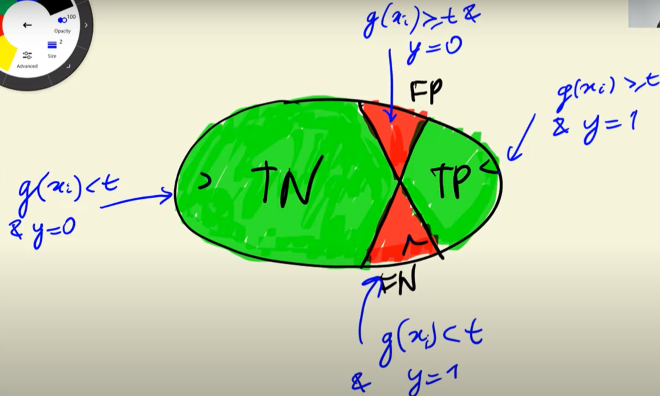

In [107]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
actual_positive, actual_negative

(array([False, False, False, ..., False,  True,  True]),
 array([ True,  True,  True, ...,  True, False, False]))

In [108]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)
predict_positive, predict_negative

(array([False, False, False, ..., False,  True,  True]),
 array([ True,  True,  True, ...,  True, False, False]))

In effect, what we are setting up is a logic AND argument.  If both are True then the output is True, if both are False then the output is True, if either is different then we get an output that is False

In [109]:
predict_positive & actual_positive

array([False, False, False, ..., False,  True,  True])

In [110]:
(predict_positive & actual_positive).sum()

210

We have 210 True Positives and 922 True Negatives

In [111]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
tp, tn

(210, 922)

We have 101 False Positives and 176 False Negatives

In [112]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()
fp, fn

(101, 176)

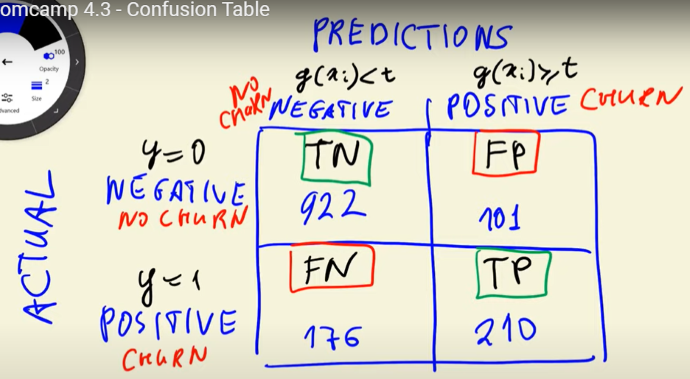

In [113]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]  
])
confusion_matrix

array([[922, 101],
       [176, 210]])

What all of this is telling us is that with our current model we would be sending out 101 discount emails to people who not at risk of churning and we would be missing out by not sending out 176 discount emails to people who were going to churn.  In the first case we are losing money because we gave discounts to people who were not at risk of churning and in the second case we are missing out on future money by not attempting to retain customers that are at high risk for churning.

In [114]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and Recall

Precision tell us the fraction of positive predictions that are correct. It takes into account only the positive class (TP and FP - second column of the confusion matrix), as is stated in the following formula:

TP / (TP + FP)

Recall measures the fraction of correctly identified postive instances. It considers parts of the postive and negative classes (TP and FN - second row of confusion table). The formula of this metric is presented below:

TP / (TP + FN)

In this problem, the precision and recall values were 67% and 54% respectively. So, these measures reflect some errors of our model that accuracy did not notice due to the class imbalance.

### Precision

In [115]:
(tp + tn) / (tp + tn + fp + fn) # accuracy score of our model

0.8034066713981547

In the precision score we are only interested in scores that equal churn.  In this case we would be interested in the TP and FP.
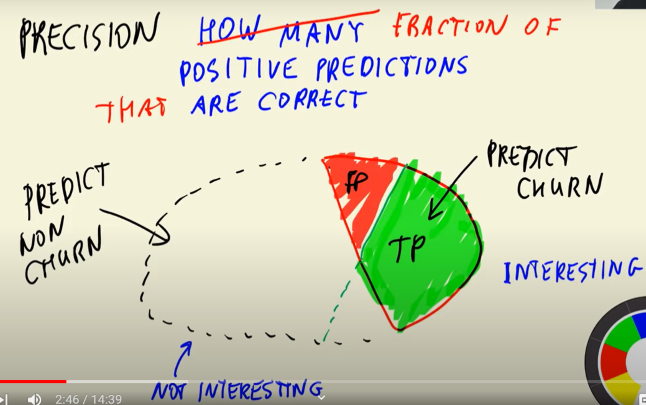

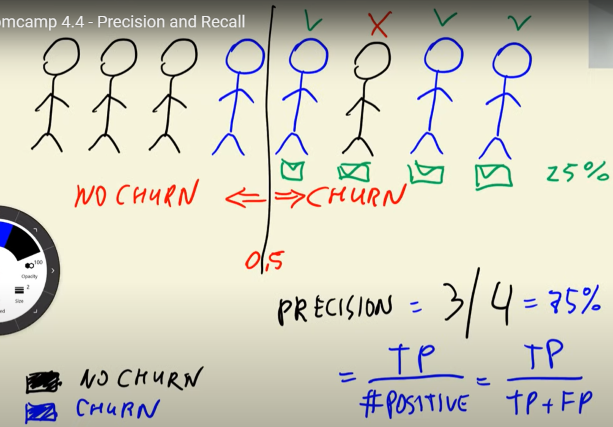

In [117]:
p = tp / (fp + tp)
p

0.6752411575562701

### Recall

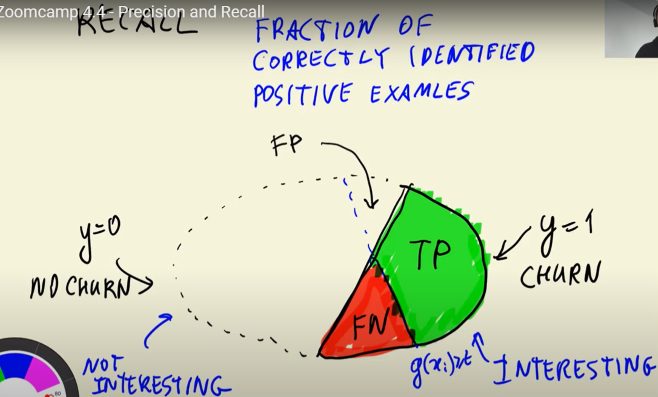

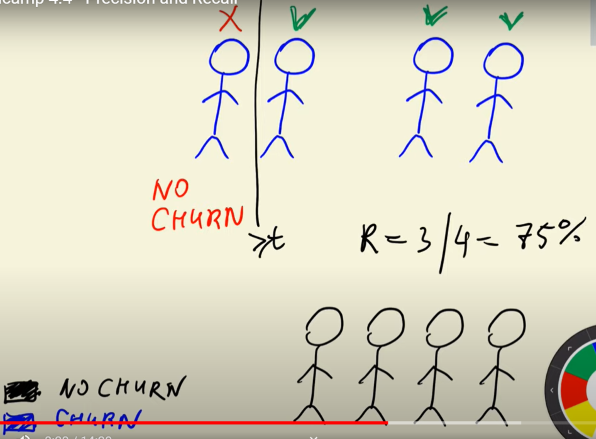

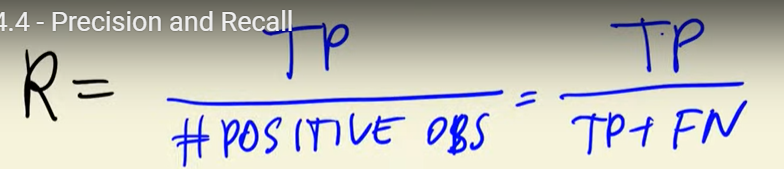

In [120]:
r = tp / (tp + fn)
r

0.5440414507772021

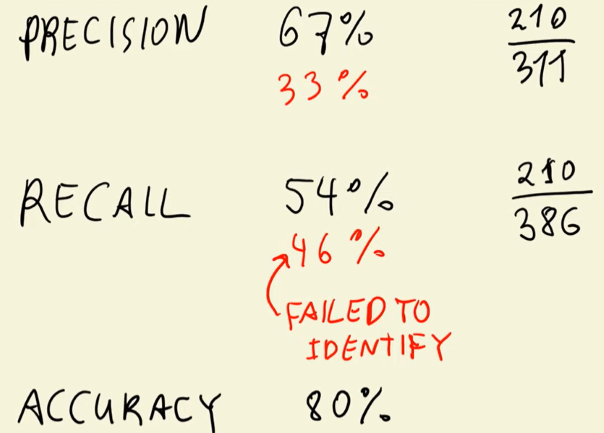

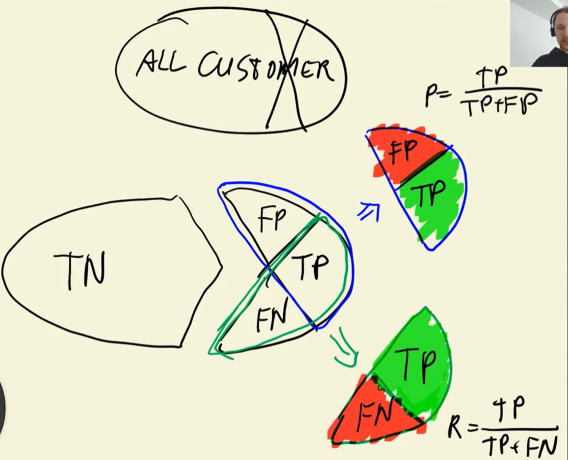

## 4.5 ROC Curves

ROC stands for Receiver Operating Characteristic, and this idea was applied during the Second World War for evaluating the strenght of radio detectors. This measure considers False Positive Rate (FPR) and True Postive Rate (TPR), which are derived from the values of the confusion matrix.

FPR is the fraction of false positives (FP) divided by the total number of negatives (FP and TN - the first row of confusion matrix), and we want to minimize it. The formula of FPR is the following:



In the other hand, TPR or Recall is the fraction of true positives (TP) divided by the total number of positives (FN and TP - second row of confusion table), and we want to maximize this metric. The formula of this measure is presented below:



ROC curves consider Recall and FPR under all the possible thresholds. If the threshold is 0 or 1, the TPR and Recall scores are the opposite of the threshold (1 and 0 respectively), but they have different meanings, as we explained before.

We need to compare the ROC curves against a point of reference to evaluate its performance, so the corresponding curves of random and ideal models are required. It is possible to plot the ROC curves with FPR and Recall scores vs thresholds, or FPR vs Recall.

Classes and methods:

- `np.repeat([x,y], [z,w])` - returns a numpy array with a z number of x values, and a w number of y values.
- `roc_curve(x, y)` - sklearn.metrics class for calculating the false positive rates, true positive rates, and thresholds, given a target x dataset and a predicted y dataset.

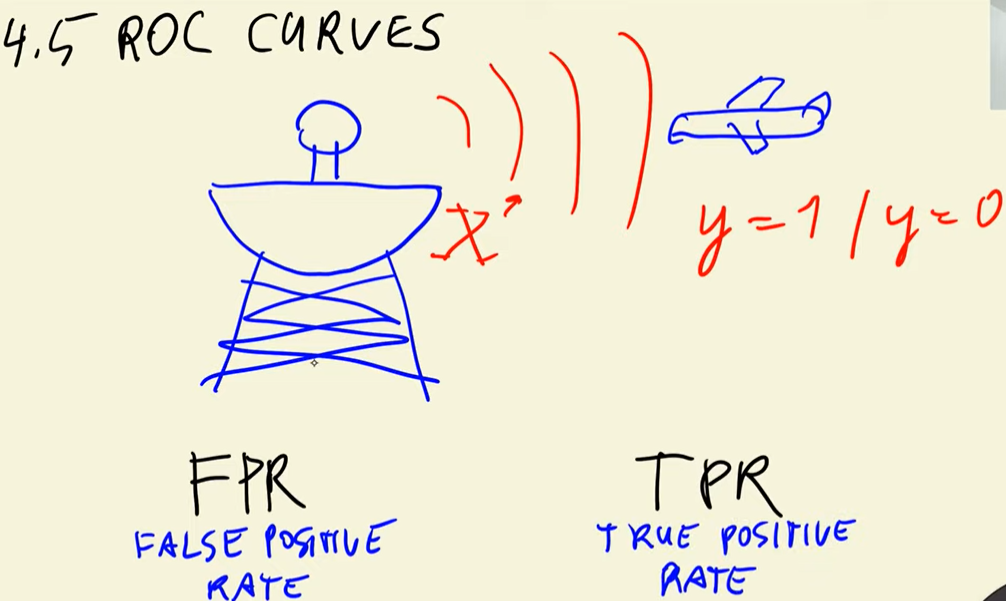

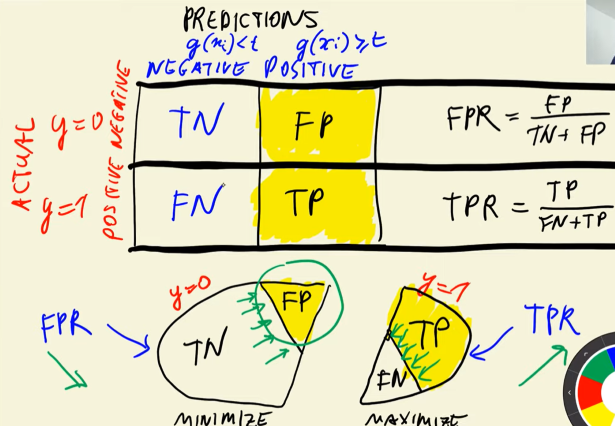

#### TPR and FPR

TPR is the same equation as recall

In [123]:
tpr = tp / (fn + tp)
tpr

0.5440414507772021

In [125]:
fpr = fp / (tn + fp)
fpr

0.09872922776148582

In [129]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [130]:
scores

[(0.0, 386, 1023, 0, 0),
 (0.01, 385, 914, 1, 109),
 (0.02, 384, 830, 2, 193),
 (0.03, 383, 766, 3, 257),
 (0.04, 381, 715, 5, 308),
 (0.05, 379, 683, 7, 340),
 (0.06, 377, 661, 9, 362),
 (0.07, 372, 640, 14, 383),
 (0.08, 371, 613, 15, 410),
 (0.09, 369, 580, 17, 443),
 (0.1, 366, 556, 20, 467),
 (0.11, 365, 528, 21, 495),
 (0.12, 365, 509, 21, 514),
 (0.13, 360, 477, 26, 546),
 (0.14, 355, 453, 31, 570),
 (0.15, 351, 435, 35, 588),
 (0.16, 347, 419, 39, 604),
 (0.17, 346, 401, 40, 622),
 (0.18, 344, 384, 42, 639),
 (0.19, 338, 369, 48, 654),
 (0.2, 333, 356, 53, 667),
 (0.21, 329, 341, 57, 682),
 (0.22, 323, 322, 63, 701),
 (0.23, 320, 313, 66, 710),
 (0.24, 316, 304, 70, 719),
 (0.25, 309, 291, 77, 732),
 (0.26, 304, 281, 82, 742),
 (0.27, 303, 270, 83, 753),
 (0.28, 295, 256, 91, 767),
 (0.29, 291, 244, 95, 779),
 (0.3, 284, 236, 102, 787),
 (0.31, 280, 230, 106, 793),
 (0.32, 278, 225, 108, 798),
 (0.33, 276, 221, 110, 802),
 (0.34, 274, 212, 112, 811),
 (0.35000000000000003, 272,

In [131]:
df_scores = pd.DataFrame(scores)

In [132]:
df_scores

0    1     2    3     4
0    0.00  386  1023    0     0
1    0.01  385   914    1   109
2    0.02  384   830    2   193
3    0.03  383   766    3   257
4    0.04  381   715    5   308
..    ...  ...   ...  ...   ...
96   0.96    0     0  386  1023
97   0.97    0     0  386  1023
98   0.98    0     0  386  1023
99   0.99    0     0  386  1023
100  1.00    0     0  386  1023

[101 rows x 5 columns]

In [134]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = columns)

In [137]:
df_scores[::10]  # looking at each 10th record

threshold   tp    fp   fn    tn
0          0.0  386  1023    0     0
10         0.1  366   556   20   467
20         0.2  333   356   53   667
30         0.3  284   236  102   787
40         0.4  249   166  137   857
50         0.5  210   101  176   922
60         0.6  151    53  235   970
70         0.7   76    20  310  1003
80         0.8   13     2  373  1021
90         0.9    0     0  386  1023
100        1.0    0     0  386  1023

In [140]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [141]:
df_scores[::10]

threshold   tp    fp   fn    tn       tpr       fpr
0          0.0  386  1023    0     0  1.000000  1.000000
10         0.1  366   556   20   467  0.948187  0.543500
20         0.2  333   356   53   667  0.862694  0.347996
30         0.3  284   236  102   787  0.735751  0.230694
40         0.4  249   166  137   857  0.645078  0.162268
50         0.5  210   101  176   922  0.544041  0.098729
60         0.6  151    53  235   970  0.391192  0.051808
70         0.7   76    20  310  1003  0.196891  0.019550
80         0.8   13     2  373  1021  0.033679  0.001955
90         0.9    0     0  386  1023  0.000000  0.000000
100        1.0    0     0  386  1023  0.000000  0.000000

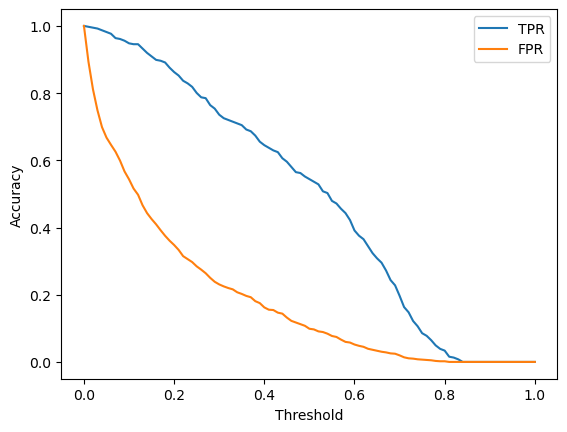

In [177]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')

plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.legend()

### Random model

In [146]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [147]:
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [148]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [154]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns = columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
        
    return df_scores

In [155]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

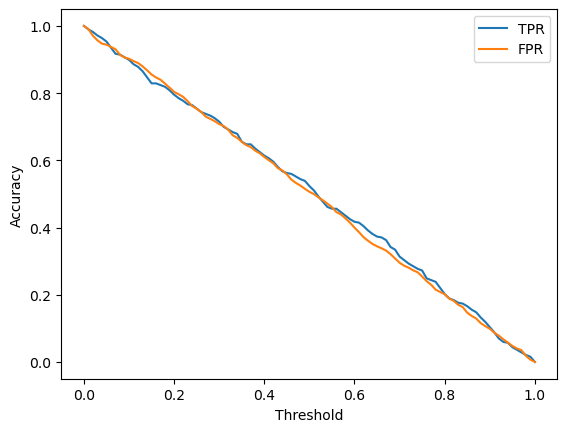

In [176]:
df_rand[::10]

plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')

plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.legend()

### Ideal model

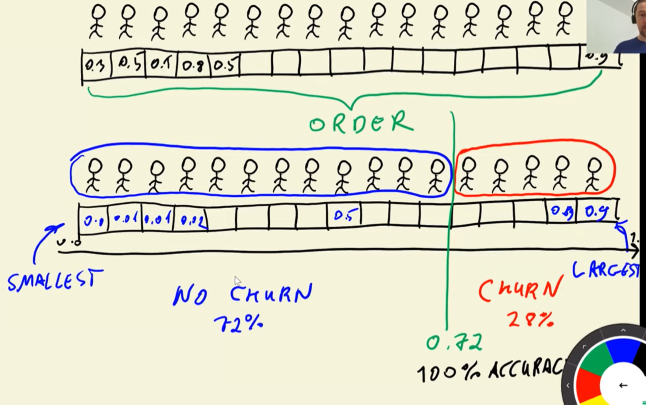

In [159]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

The `np.repeat` function will create an array with 0's the number of times of num_neg and 1's the number of times of num_pos. This creates the order in the second set in the image.

In [161]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [163]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [166]:
1 - y_val.mean()

0.7260468417317246

In [165]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [167]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

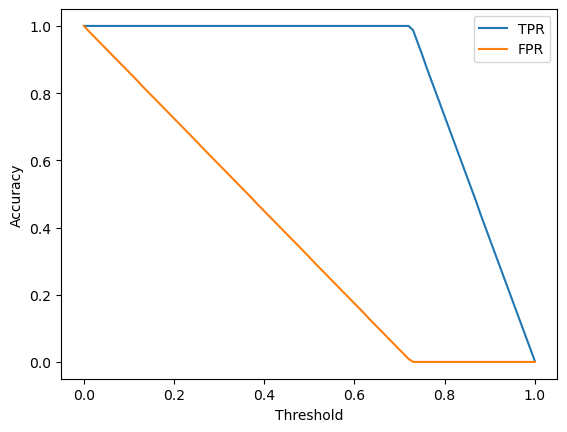

In [175]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')

plt.xlabel('Threshold')
plt.ylabel('Accuracy')


plt.legend()

### Putting it all together

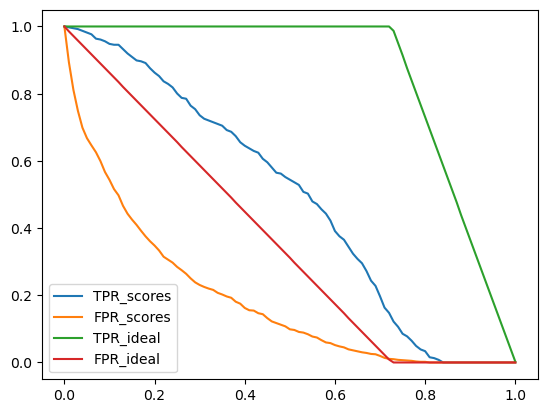

In [171]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR_scores')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR_scores')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR_ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR_ideal')

#plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR_rand')
#plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR_rand')

plt.legend()

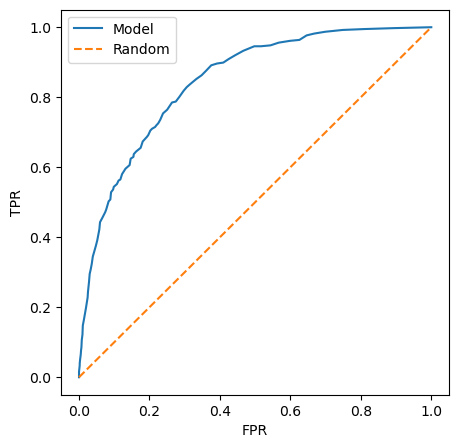

In [180]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
#plt.plot(df_rand.fpr, df_rand.tpr, label='random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

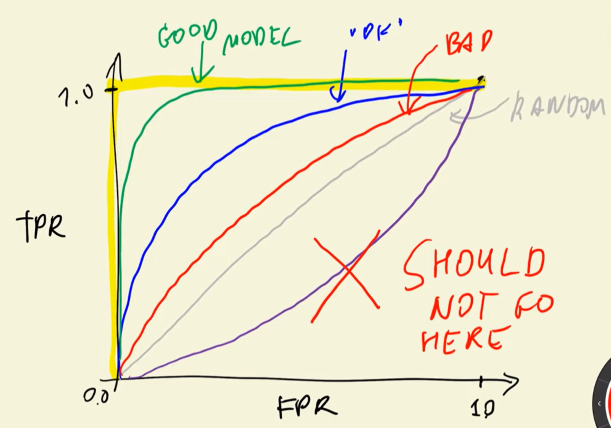

In [181]:
from sklearn.metrics import roc_curve

In [182]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

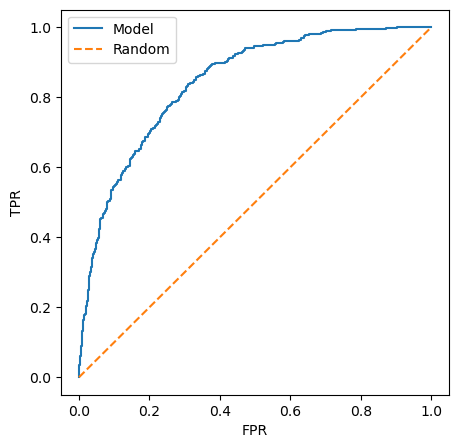

In [183]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 ROC AUC

The Area under the ROC curves can tell us how good is our model with a single value. The AUROC of a random model is 0.5, while for an ideal one is 1.

In ther words, AUC can be interpreted as the probability that a randomly selected positive example has a greater score than a randomly selected negative example.

Classes and methods:

- `auc(x, y)` - sklearn.metrics class for calculating area under the curve of the x and y datasets. For ROC curves x would be false positive rate, and y true positive rate.
- `roc_auc_score(x, y)` - sklearn.metrics class for calculating area under the ROC curves of the x false positive rate and y true positive rate datasets.

In [184]:
from sklearn.metrics import auc

In [185]:
auc(fpr, tpr)

0.8438302463039216

In [187]:
auc(df_scores.fpr, df_scores.tpr)

0.8438365773732646

In [188]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [196]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438302463039216

In [197]:
from sklearn.metrics import roc_auc_score

In [198]:
roc_auc_score(y_val, y_pred)

0.8438302463039216

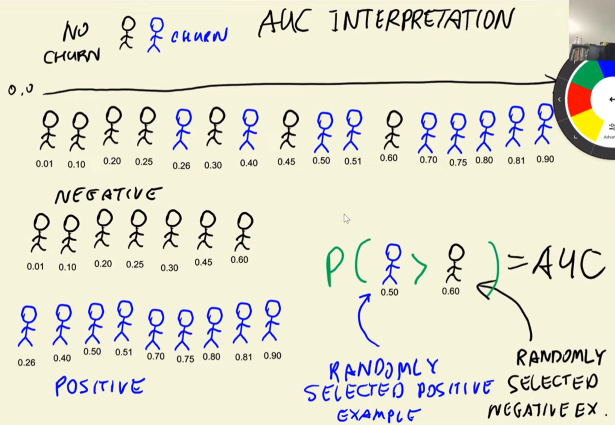

In [199]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]
neg

array([0.00899416, 0.20483208, 0.21257239, ..., 0.10764076, 0.31400436,
       0.13641188])

In [200]:
import random

Below is an example of how `roc_auc_score` is actually calculated

In [207]:
n = 1000000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1
success / n

0.843749

We can also do this with Numpy

In [209]:
n = 1000000

random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.843908

## 4.7 Cross-Validation

Extra resources
In the lesson we talked about iterators and generators in Python. You can read more about them here:

- https://anandology.com/python-practice-book/iterators.html
- https://www.google.com/search?q=python+iterators+and+generators

Notes

Cross-validation refers to evaluating the same model on different subsets of a dataset, getting the average prediction, and spread within predictions. This method is applied in the parameter tuning step, which is the process of selecting the best parameter.

In this algorithm, the full training dataset is divided into k partitions, we train the model in k-1 partiions of this dataset and evaluate it on the remaining subset. Then, we end up evaluating the model in all the k folds, and we calculate the average evaluation metric for all the folds.

In general, if the dataset is large, we should use the hold-out validation dataset strategy. In the other hand, if the dataset is small or we want to know the standard deviation of the model across different folds, we can use the cross-validation approach.

Libraries, classes and methods:

- `Kfold(k, s, x)` - sklearn.model_selection class for calculating the cross validation with k folds, s boolean attribute for shuffle decision, and an x random state
- `Kfold.split(x)` - sklearn.Kfold method for splitting the x dataset with the attributes established in the Kfold's object construction.
- `for i in tqdm()` - library for showing the progress of each i iteration in a for loop.

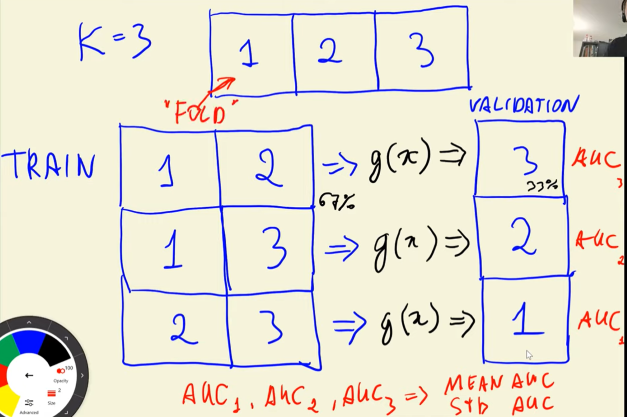

In [237]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [240]:
dv, model = train(df_train, y_train, C=0.001)

In [213]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [215]:
y_pred = predict(df_val, dv, model)

In [217]:
from sklearn.model_selection import KFold

In [218]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
train_idx, val_idx = next(kfold.split(df_full_train))

tqdm is a package that allows us to see progress bars during iteration functions.

In [228]:
import sys
!conda install --yes --prefix {sys.prefix} tqdm

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\daver\Desktop\DataScience\zoomcamp\env

  added / updated specs:
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2022.9.14          |  py310haa95532_0         155 KB
    tqdm-4.64.0                |  py310haa95532_0         156 KB
    ------------------------------------------------------------
                                           Total:         312 KB

The following NEW packages will be INSTALLED:

  tqdm               pkgs/main/win-64::tqdm-4.64.0-py310haa95532_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2022.9.1~ --> pkgs/main::ca-certificates-2022.07.19-haa95532_0
  certifi            conda-forge/noarch::certifi-2022.9.14~ --> pkgs/main/win-64::certifi-2022.9.14-py310haa95532_0
  open



==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [229]:
from tqdm.auto import tqdm

In [245]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))    

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.841 +- 0.007
C=1 0.841 +- 0.008
C=5 0.840 +- 0.008
C=10 0.841 +- 0.007


Above we see the scores and they are all very similar, 0.001 is the lowest.  All the rest are very close and since C=1.0 is the default we will just use that. Since all the scores were very similar we can run the model on the test data set.

In [246]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

## 4.8 Summary

General definitions:

- Metric: A single number that describes the performance of a model
- Accuracy: Fraction of correct answers; sometimes misleading
- Precision and recall are less misleading when we have class inbalance
- ROC Curve: A way to evaluate the performance at all thresholds; okay to use with imbalance
- K-Fold CV: More reliable estimate for performance (mean + std)

In brief, this weeks was about different metrics to evaluate a binary classifier. These measures included accuracy, confusion table, precision, recall, ROC curves(TPR, FRP, random model, and ideal model), and AUROC. Also, we talked about a different way to estimate the performance of the model and make the parameter tuning with cross-validation.

## 4.9 Explore more

- Check the precision and recall of the dummy classifier that always predict "FALSE"
- F1 score = 2 P R / (P + R)
- Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
- Area under the PR curve is also a useful metric

Other projects
- Calculate the metrics for the suggested datasets from the previous week
